In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import timeit

from queue import PriorityQueue
from sklearn.neighbors import NearestNeighbors
from numba import jit
from itertools import chain

%matplotlib inline

In [499]:
data_file = "./data/tsp_574_1"
data = pd.read_csv(data_file, sep=" ", names=["x", "y"], dtype={"x":float, "y":float})

In [500]:
data.head()

,x,y
0,574.00,NaN
1,1916.09,2076.89
2,1852.60,2140.39
3,1827.21,2165.80
4,1814.49,2229.30


In [501]:
n = int(data["x"][0])

In [502]:
class Vertex:
    
    def __init__(self, index, x, y):
        self.index = index
        self.x = x
        self.y = y

class Distance(object):

    def __init__(self, solution, distance):
        self.solution = solution
        self.distance = distance

    def __lt__(self, other):
        return self.distance < other.distance
    
class VertexDistance(object):

    def __init__(self, index, distance):
        self.index = index
        self.distance = distance
        
    def __lt__(self, other):
        return self.distance < other.distance


vertices = []
points = np.zeros((n, 2))
for i in range(1, n+1):
    vertices.append(Vertex(i-1, data["x"][i], data["y"][i]))
    points[i-1,:] = np.array([data["x"][i], data["y"][i]])

In [503]:
def plotTSP(paths, points, num_iters=1):

    """
    path: List of lists with the different orders in which the nodes are visited
    points: coordinates for the different nodes
    num_iters: number of paths that are in the path list
    
    """

    # Unpack the primary TSP path and transform it into a list of ordered 
    # coordinates

    x = []; y = []
    for i in paths[0]:
        x.append(points[i, 0])
        y.append(points[i, 1])
    plt.plot(x, y, 'co')

    # Set a scale for the arrow heads (there should be a reasonable default for this, WTF?)
    a_scale = float(max(x))/float(100)

    # Draw the older paths, if provided
    if num_iters > 1:

        for i in range(1, num_iters):

            # Transform the old paths into a list of coordinates
            xi = []; yi = [];
            for j in paths[i]:
                xi.append(points[j, 0])
                yi.append(points[j, 1])

            plt.arrow(xi[-1], yi[-1], (xi[0] - xi[-1]), (yi[0] - yi[-1]), 
                    head_width = a_scale, color = 'r', 
                    length_includes_head = True, ls = 'dashed',
                    width = 0.001/float(num_iters))
            for i in range(0, len(x) - 1):
                plt.arrow(xi[i], yi[i], (xi[i+1] - xi[i]), (yi[i+1] - yi[i]),
                        head_width = a_scale, color = 'r', length_includes_head = True,
                        ls = 'dashed', width = 0.001/float(num_iters))

    # Draw the primary path for the TSP problem
    plt.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width = a_scale, 
            color ='g', length_includes_head=True)
    for i in range(0,len(x)-1):
        plt.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width = a_scale,
                color = 'g', length_includes_head = True)

    #Set axis too slitghtly larger than the set of x and y
    plt.xlim(-1, max(x)*1.1)
    plt.ylim(-1, max(y)*1.1)
    plt.show()

In [504]:
def euclidean_distance(vertex_1, vertex_2):
    return np.sqrt( np.square(vertex_1.x - vertex_2.x)  + np.square(vertex_1.y - vertex_2.y) )

def path_distance(r, c):
    r = [x.index for x in r]
    return np.sum([np.linalg.norm(c[r[p]]-c[r[p-1]]) for p in range(len(r))])

def compute_distance_matrix(vertices, n):
    all_pairs = [(i, j) for i in range(0, n) for j in range(0, n) if i != j]
    dist_matrix = np.zeros((n, n))
    for k in all_pairs:
        x = k[0]; y = k[1]
        dist_matrix[x, y] = euclidean_distance(vertices[x], vertices[y])
    return dist_matrix

def compute_tour_distance(route, dist_matrix):
    head_route = route[:-1]
    tail_route = route[1:]
    pair_route = zip(head_route, tail_route)    
    return sum(map(lambda pair: dist_matrix[pair[0].index, pair[1].index], pair_route))

def test(vertex1, vertex2, dist_matrix):
    if (dist_matrix[vertex1.index, vertex2.index] == 0):
        dist_matrix[vertex1.index, vertex2.index] = euclidean_distance(vertex1, vertex2)
    return dist_matrix[vertex1.index, vertex2.index]

def compute_tour_distance_2(route, dist_matrix):
    head_route = route[:-1]
    tail_route = route[1:]
    pair_route = zip(head_route, tail_route)    
    return sum(map(lambda pair: test(pair[0], pair[1], dist_matrix), pair_route))

def objective_function(route):
    """
    Assume vertices is route starting and ending at same vertex e.g.
    [1, 3, 2, 0, 1]
    """
    head_route = route[0:(len(route)-1)]
    tail_route = route[1:]
    combined_route = zip(head_route, tail_route)
    dist_sum = sum(list(map(lambda x: euclidean_distance(x[0], x[1]), combined_route)))
    return dist_sum
     
def is_valid_hamiltonian_cycle(route, n):
    # Ensure it starts and ends at same node
    start_and_end = route[0] == route[-1]
    
    # Need to ensure all vertices 0,..,n-1 are present
    all_index = list(range(0, n))
    indexes = sorted(list(set([vertex.index for vertex in route])))
    index_present = all_index == indexes
    
    return start_and_end and index_present

def tour_string(vertices):
    return " ".join([str(i.index) for i in vertices])

def tour_list(vertices):
    return [i.index for i in vertices]

# Improved NN approach
def nearest_neighbour_improved(vertices, n, points, max_search=0):
    nn_max = min(n, 500)
    remaining_indexes = set(range(0, n))
    starting_vertex = np.random.randint(0, n)
    remaining_indexes.remove(starting_vertex)
    tour = [vertices[starting_vertex]]
    used_index = set([starting_vertex])
    
    nbrs = NearestNeighbors(n_neighbors=nn_max, algorithm='auto').fit(points)
    distances, indices = nbrs.kneighbors(points)
    
    while len(remaining_indexes) > 0:
        cur_vertex = tour[-1]
        # Search nearest neighbours first
        nn_index = indices[cur_vertex.index]
        found_in_nearest = False
        for i in nn_index[1:]:
            if i not in used_index:
                # Found nearest, update the tour
                tour.append(vertices[i])
                remaining_indexes.remove(i)
                    
                used_index.add(i)
                found_in_nearest = True
                break
                
        if not found_in_nearest:
            solution_queue = PriorityQueue()

            num_checked = 0
            for i in remaining_indexes:
                dist = euclidean_distance(cur_vertex, vertices[i])
                solution_queue.put(VertexDistance(i, dist))
                num_checked += 1

                if (max_search != 0 and num_checked > max_search):
                    break

            # Select the shortest distance
            nearest = solution_queue.get()

            # Update the tour
            tour.append(vertices[nearest.index])
            remaining_indexes.remove(nearest.index)
            used_index.add(nearest.index)
            
    # Add final node to tour
    tour.append(tour[0])
        
    return tour
    
def two_opt_swap(i, j, route, n):
    new_route = route[:]
    new_route[i:j] = route[j-1:i-1:-1] # this is the 2woptSwap
    return new_route

def two_opt_full(vertices, n, points, dist_matrix, seconds_timeout = 180):
        
    route = nearest_neighbour_improved(vertices, n, points)
    cur_distance = compute_tour_distance(route, dist_matrix)
    start_time = round(time.time())
    max_neighbour_size = 90000
    
    while True:
        print(cur_distance)
        
        # Check timeout
        time_now = round(time.time())
        time_diff = time_now - start_time
        if (seconds_timeout != -1 and time_diff > seconds_timeout):
            print("TIMEOUT")
            break

        neighbours = [(i, j) for i in range(1, n) for j in range(i+1, len(route)) if j - i > 1]
        routes = list(map(lambda x : two_opt_swap(x[0], x[1], route, n), neighbours))
        if len(routes) > max_neighbour_size:
            routes = random.sample(routes, max_neighbour_size)
        
        distances = list(map(lambda x : compute_tour_distance(x, dist_matrix), routes))

        y = np.argmin(distances)
        best_move = routes[y]
        best_distance = distances[y]

        if (best_distance < cur_distance):
            cur_distance = best_distance
            route = best_move
        else:
            break
            
    return route

def iterated_local_search(vertices, n, points, dist_matrix, max_searches = 3, seconds_timeout = 180):
    
    cur_route = nearest_neighbour_improved(vertices, n, points)
    cur_distance = compute_tour_distance(cur_route, dist_matrix)

    best_route = cur_route
    best_distance = cur_distance
    
    for i in range(0, max_searches):
    
        # Start at new random location each time 2opt is run
        cur_route =  tabu_search(vertices, n, points, dist_matrix, seconds_timeout)
        cur_distance = compute_tour_distance(cur_route, dist_matrix)

        if (cur_distance < best_distance):
            best_distance = cur_distance
            best_route = cur_route        
    
    return best_route

def tabu_search(vertices, n, points, dist_matrix, seconds_timeout = 180):
        
    route = nearest_neighbour_improved(vertices, n, points)
    cur_distance = compute_tour_distance(route, dist_matrix)
    start_time = round(time.time())
    max_neighbour_size = 20000
    tabu_list = np.zeros((n+1, n+1))
    L = 10
    it = 0
    
    while True:
        print(cur_distance)
        it += 1
        
        # Check timeout
        time_now = round(time.time())
        time_diff = time_now - start_time
        if (seconds_timeout != -1 and time_diff > seconds_timeout):
            print("TIMEOUT")
            break

        neighbours = [(i, j) for i in range(1, n) for j in range(i+1, len(route)) if j - i > 1 and 
                      tabu_list[i, j] <= it]
        print(len(neighbours))
        if len(neighbours) == 0:
            # reset
            tabu_list = np.zeros((n+1, n+1))
            it = 1
            neighbours = [(i, j) for i in range(1, n) for j in range(i+1, len(route)) if j - i > 1 and 
                      tabu_list[i, j] <= it]
        
        if len(neighbours) > max_neighbour_size:
            neighbours = random.sample(neighbours, max_neighbour_size)
        routes = list(map(lambda x : two_opt_swap(x[0], x[1], route, n), neighbours))    
        distances = list(map(lambda x : compute_tour_distance(x, dist_matrix), routes))
        # Update tabu_list
        for x in neighbours:
            tabu_list[x[0], x[1]] = tabu_list[x[0], x[1]] + L
        
        y = np.argmin(distances)
        best_move = routes[y]
        best_distance = distances[y]

        if (best_distance < cur_distance):
            cur_distance = best_distance
            route = best_move
        else:
            break
            
    return route

def tabu_search2(vertices, n, points, dist_matrix, seconds_timeout = 180):
        
    route = nearest_neighbour_improved(vertices, n, points)
    cur_distance = compute_tour_distance_2(route, dist_matrix)
    start_time = round(time.time())
    max_neighbour_size = 10000
    tabu_list = np.zeros((n+1, n+1))
    L = 40
    it = 0
    
    while True:
        print(cur_distance)
        it += 1
        
        # Check timeout
        time_now = round(time.time())
        time_diff = time_now - start_time
        if (seconds_timeout != -1 and time_diff > seconds_timeout):
            print("TIMEOUT")
            break

        # Ranomdely select some points
        sample_points = random.sample(range(1,n), min(300, n))
        neighbours = [(i, j) for i in sample_points for j in range(i+1, min(i+200, len(route))) if j - i > 1 and 
                      tabu_list[i, j] <= it]
        print(len(neighbours))
        if len(neighbours) == 0:
            # reset
            tabu_list = np.zeros((n+1, n+1))
            it = 1
            neighbours = [(i, j) for i in range(1, n) for j in range(i+1, len(route)) if j - i > 1 and 
                      tabu_list[i, j] <= it]
        
        if len(neighbours) > max_neighbour_size:
            neighbours = random.sample(neighbours, max_neighbour_size)
        routes = list(map(lambda x : two_opt_swap(x[0], x[1], route, n), neighbours))    
        distances = list(map(lambda x : compute_tour_distance_2(x, dist_matrix), routes))
        # Update tabu_list
        for x in neighbours:
            tabu_list[x[0], x[1]] = tabu_list[x[0], x[1]] + L
        
        y = np.argmin(distances)
        best_move = routes[y]
        best_distance = distances[y]

        if (best_distance < cur_distance):
            cur_distance = best_distance
            route = best_move
        else:
            break
            
    return route
    
# 3 opt
# k-opt

In [505]:
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

def rotate(l, n):
    return l[n:] + l[:n]

def three_opt_neighbours_random(route, sample_size, tabu_list, it):
    n = len(route)
    if (n * n/2 * n/4 < sample_size): # Very approximate approach to find out whether we should do full enumeration
        return three_opt_neighbours(route, tabu_list, it)
    else:
        samples = list(set(list(map(lambda x : tuple(sorted(random.sample(range(1, n-1), 3))), range(0, sample_size)))))
        return list(filter(lambda x: tabu_list[x[0], x[1], x[2]] <= it, samples))

def three_opt_neighbours(route, tabu_list, it):
    n = len(route)
    return [(i, j, k) for i in range(1, n-1) for j in range(i+1, n-1) for k in range(j+1, n-1) if 
            tabu_list[i, j, k] <= it]

def three_opt_swap(route, move):
    p = route
    a, c, e = move
    # without loss of generality, sort
    a, c, e = sorted([a, c, e])
    b, d, f = a+1, c+1, e+1

    return [p[:a+1] + p[b:c+1]    + p[e:d-1:-1] + p[f:], # 2-opt
    p[:a+1] + p[c:b-1:-1] + p[d:e+1]    + p[f:], # 2-opt
    p[:a+1] + p[c:b-1:-1] + p[e:d-1:-1] + p[f:], # 3-opt
    p[:a+1] + p[d:e+1]    + p[b:c+1]    + p[f:], # 3-opt
    p[:a+1] + p[d:e+1]    + p[c:b-1:-1] + p[f:], # 3-opt
    p[:a+1] + p[e:d-1:-1] + p[b:c+1]    + p[f:], # 3-opt
    p[:a+1] + p[e:d-1:-1] + p[c:b-1:-1] + p[f:]] # 2-opt

def three_opt_full(vertices, n, points, dist_matrix, seconds_timeout = 180):
        
    route = nearest_neighbour_improved(vertices, n, points)
    cur_distance = compute_tour_distance(route, dist_matrix)
    start_time = round(time.time())
    max_neighbour_size = 20000
    tabu_list = np.zeros((n+1, n+1, n+1))
    L = 30
    it = 0
    max_end_points = 5
    cur_end_point = 0
    
    while True:
        print(cur_distance)
        it += 1
        
        # Check timeout
        time_now = round(time.time())
        time_diff = time_now - start_time
        if (seconds_timeout != -1 and time_diff > seconds_timeout):
            print("TIMEOUT")
            break

        neighbours = three_opt_neighbours_random(route, max_neighbour_size, tabu_list, it)
        
        if len(neighbours) == 0:
            # reset
            tabu_list = np.zeros((n+1, n+1, n+1))
            it = 1
            neighbours = three_opt_neighbours_random(route, max_neighbour_size, tabu_list, it)
        
        routes = list(flatmap(lambda x : three_opt_swap(route, x), neighbours))
        distances = list(map(lambda x : compute_tour_distance(x, dist_matrix), routes))
        # Update tabu_list
        for x in neighbours:
            tabu_list[x[0], x[1], x[2]] = tabu_list[x[0], x[1], x[2]] + L

        y = np.argmin(distances)
        best_move = routes[y]
        best_distance = distances[y]

        if (best_distance < cur_distance):
            cur_distance = best_distance
            route = best_move
            cur_end_point = 0
        else:
            if cur_end_point >= max_end_points:
                break
            else:
                cur_end_point += 1
                # reset
                tabu_list = np.zeros((n+1, n+1, n+1))
                it = 1
            
        # Rotate the route, ensures the first elements get a chance to be swapped       
        route = route[:-1]  # Take final node off
        route = rotate(route, np.random.randint(1, n)) # Rotate by at least one
        route.append(route[0]) # Add final node back on
            
    return route

def iterated_local_search_3opt(vertices, n, points, dist_matrix, max_searches = 3, seconds_timeout = 180):
    
    cur_route = nearest_neighbour_improved(vertices, n, points)
    cur_distance = compute_tour_distance(cur_route, dist_matrix)

    best_route = cur_route
    best_distance = cur_distance
    
    for i in range(0, max_searches):
    
        # Start at new random location each time 2opt is run
        cur_route =  three_opt_full(vertices, n, points, dist_matrix, seconds_timeout)
        cur_distance = compute_tour_distance(cur_route, dist_matrix)

        if (cur_distance < best_distance):
            best_distance = cur_distance
            best_route = cur_route        
    
    return best_route

In [506]:
class SimulatedAnnealing():
    
    max_temp = 500
    max_time = 1000
    sample_size = 10000
    
    def temperature(self, t):
        T = t * float(-self.max_temp) / self.max_time + self.max_temp
        if T < 0:
            return 0
        return T
    
    def probability(self, delta, t):
        if delta < 0:
            return 1
        else:
            T = self.temperature(t)
            if T <= 0:
                return 0
            P = np.exp(-delta / T)
            if P > 1:
                P = 1
            elif P < 0:
                P = 0
            return P
        
    def sa_search(self, vertices, n, points, dist_matrix, seconds_timeout = 180):
        cur_route = nearest_neighbour_improved(vertices, n, points)
        cur_distance = compute_tour_distance_2(cur_route, dist_matrix)
        best_ever_route = cur_route
        best_ever_distance = cur_distance
        
        start_time = round(time.time())
        it = 0
        
        while True:
            print(cur_distance)
            
            # Check timeout
            time_now = round(time.time())
            time_diff = time_now - start_time
            if (seconds_timeout != -1 and time_diff > seconds_timeout):
                print("TIMEOUT")
                break

            neighbours = three_opt_neighbours_random(cur_route, self.sample_size)
           
            np.random.shuffle(neighbours)
            found_move = False
            for x in neighbours:
                new_routes = three_opt_swap(cur_route, x)
                # Take the best from the 3-opt routes
                distances = list(map(lambda x : compute_tour_distance_2(x, dist_matrix), new_routes))
                
                y = np.argmin(distances)
                new_route = new_routes[y]
                new_distance = distances[y]
                                
                if self.probability(new_distance - cur_distance, it) > np.random.random():
                    cur_route = new_route
                    cur_distance = new_distance
                    found_move = True
                    break

            if (cur_distance < best_ever_distance):
                best_ever_distance = cur_distance
                best_ever_route = cur_route
           
            if found_move == False:
                break
                
            it += 1
            
        return best_ever_route


In [507]:
if n <= 500:
    dist_matrix = compute_distance_matrix(vertices, n)
    solution = iterated_local_search_3opt(vertices, n, points, dist_matrix, max_searches = max(round(10000 / ( n* 10)), 1), seconds_timeout = 2400)
elif n <= 10000:
    dist_matrix = compute_distance_matrix(vertices, n)
    solution = iterated_local_search_3opt(vertices, n, points, dist_matrix, max_searches = max(round(10000 / ( n* 10)), 1), seconds_timeout = 6000)
else:    
    dist_matrix = np.zeros((n, n))
    solution = tabu_search2(vertices, n, points, dist_matrix, 300)
distance = objective_function(solution)

47436.2782564
47183.9824374
46847.5476898
46382.6342827
46192.9249033
45844.0398329
45322.4947295
45105.9944583
44841.8623093
44704.2701782
44573.8964273
44311.8271101
44141.3590205
44026.9041927
43899.9786277
43741.7648036
43596.0508971
43449.1122543
43315.9438669
43212.6446009
43092.254036
43005.4404566
42895.1440654
42783.6077729
42696.5209128
42603.5294568
42514.8547752
42424.0460999
42335.3501298
42254.0184314
42092.3855038
42020.9302698
41972.3091939
41913.3103319
41784.7041042
41682.4928984
41621.6613016
41571.6377358
41488.1937697
41425.4587471
41346.2406964
41242.4573962
41187.1053515
41129.1363091
41075.1718935
41019.4213765
40969.5734883
40929.3940923
40881.2556228
40841.4661759
40778.9256773
40733.7607185
40663.2528458
40616.9903627
40569.4549654
40529.3737681
40497.161092
40474.1978819
40426.2922364
40395.8972735
40360.1706445
40308.1820737
40271.9095078
40246.943469
40222.8427401
40206.7346584
40185.2941776
40166.6202698
40126.1840824
40106.4862406
40082.6257089
40022.064

KeyboardInterrupt: 

In [433]:
print(is_valid_hamiltonian_cycle(solution, n))
print( tour_list(solution))

True
[50, 39, 43, 29, 21, 37, 20, 25, 1, 31, 22, 48, 49, 17, 32, 0, 33, 5, 2, 28, 10, 9, 45, 27, 47, 26, 6, 36, 12, 30, 23, 34, 24, 41, 3, 46, 8, 4, 35, 13, 7, 19, 40, 11, 42, 18, 16, 44, 14, 15, 38, 50]


In [341]:
if n <= 10000:
    dist_matrix = compute_distance_matrix(vertices, n)
    solution = iterated_local_search_3opt(vertices, n, points, dist_matrix, max_searches = 3, seconds_timeout = 2400)
else:
    dist_matrix = np.zeros((n, n))
        solution = tabu_search2(vertices, n, points, dist_matrix, 6000)

74327.4836886
1648020
74225.1931035
1628020
74112.8747585
1608020


KeyboardInterrupt: 

In [459]:
print(path_distance(solution, points))

21298.9777479


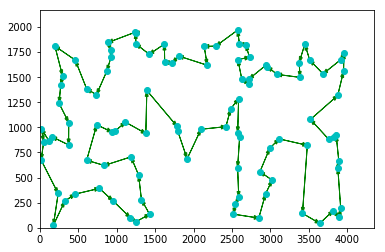

In [460]:
plotTSP([tour_list(solution)[:-1]], points)

In [90]:
i = 2
neighbours = [(i, j) for j in range(i+1, 5)]
neighbours

[(2, 3), (2, 4)]

In [30]:
a = np.zeros((3,3))

def changeit(a):
    a[0,0] = 1
    print(a)

changeit(a)
print(a)
print(sum(sum(a)))

[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
1.0


In [415]:
list(range(1, n+1))

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51]

In [ ]:
if n <= 150:
    solution = two_opt_full(vertices, n, points)
elif n <= 500:
    solution = iterated_local_search_2(vertices, n, points)
elif n <= 1000:
    solution = iterated_local_search_3(vertices, n, points)
elif n <= 2000:
    solution = metropolis_search_2(vertices, n, points)
else:
    solution = metropolis_search(vertices, n, points, 500)